In [1]:
from scipy import *
import numpy as np
import WLanalysis
from matplotlib import pyplot

In [2]:
from matplotlib.patches import Ellipse
def plotEllipse(pos,P,edge,ls,ilabel,ax):
    '''plot the contour for covariance p
    where position is the center position
    p is the covariance [2,2] matirx'''
    U, s, Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), 
                          height=2.0*math.sqrt(s[1]), angle=orient,edgecolor=edge, fill = 0, label=ilabel,ls=ls,linewidth=1.5)
    ax.add_patch(ellipsePlot)
    return ellipsePlot

In [3]:
def Fisher(covI, der, skyscaling= 1.0 ):
    '''
    Input: 
    covariance inverse matrix (Nbin, Nbin)
    derivatives (Nparams, Nbin), where Nparams is the number of parameters 
    skyscaling = area_sims / area_actual_survey = 12.25/2e4 for our sim and LSST
    Return the Fisher matrix
    '''
    Nparams, Nbin = der.shape
    F = zeros( shape= (Nparams, Nparams))
    for i in range(Nparams):
        for j in range(Nparams):
            dA, dB = der[i], der[j]
            Mij = mat(dA).T*mat(dB) + mat(dB).T*mat(dA)  
            F [i,j]= 0.5*trace(covI*Mij)
    F /= skyscaling
    Ferr = real(sqrt(mat(F).I)) [range(Nparams), range(Nparams)]
    return F, Ferr

In [8]:
########### generate parameters for all models for emulator
########### also generate parameters for fisher derivatives

params = genfromtxt('cosmo_params_all.txt',usecols=[2,3,4])

ir = 0.05

fidu_params = (0.1, 0.3, 2.1)
params_der = array( [[[0.1*(1.0-ir/2), 0.3, 2.1],[0.1*(1.0+ir/2), 0.3, 2.1]] ,
                    [[0.1, 0.3*(1.0-ir/2), 2.1],[0.1, 0.3*(1.0+ir/2), 2.1]] ,
                    [[0.1, 0.3, 2.1*(1.0-ir/2)],[0.1, 0.3, 2.1*(1.0+ir/2)]]] )
print params_der.shape

print 'parameters used for derivatives:'
for i in range(3):
    print params_der[i][0], params_der[i][1], fidu_params[i]*ir

(3, 2, 3)
parameters used for derivatives:
[ 0.0975  0.3     2.1   ] [ 0.1025  0.3     2.1   ] 0.005
[ 0.1     0.2925  2.1   ] [ 0.1     0.3075  2.1   ] 0.015
[ 0.1     0.3     2.0475] [ 0.1     0.3     2.1525] 0.105


In [74]:
########### some constants
z_source = arange(0.5,3,0.5)
Nsum = 210**2 ##### this is the total pixel in mat's downgraded map
fn_list = genfromtxt('cosmo_params_all.txt',usecols=1, dtype='string')
Nc = 3 ## compression for 2dpdf
Nmin = 5 ## min number of counts in a bin to include

In [49]:
########## generate average statistics for emulator 

### 2d pdf
pdf2dI = array([load('stats_avg/output_eb_5000_s4_ALL_igalXicmb_2dpdf_%.1f_1.0_1.0.npy'
                     %(iz)) for iz in z_source])
pdf2dN = array([load('stats_avg/output_eb_5000_s4_ALL_galXcmb_2dpdf_%.1f_1.0_1.0.npy'
                     %(iz)) for iz in z_source])

### 1d pdf
pdf1dI = sum(pdf2dI, axis=2)
pdf1dN = sum(pdf2dN, axis=2)

### power spectrum from mat
psI_Mat = array([load('stats_avg/output_eb_5000_s4_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
psN_Mat = array([load('stats_avg/output_eb_5000_s4_ALL_galXgal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])

### power spectrum from Jose
ellJ, testPS = load('ObsFeb2018_Spec/%s/Maps05/PS_KN_s0.00_z0.50_ng08.83_b050_Mean.npy'%(fn_list[1]))
idxJ = where((ellJ<3000) & (testPS>0) )[0]

psI_Jose = array([[mean(load('/Users/jia/Dropbox/fisher/powerspectrum_noiseless/%s_PS_50_z%02d.npy'
        %(icosmo,iz*10))[1:],axis=0) for icosmo in fn_list[1:]] for iz in z_source]).reshape(100, 5, -1)[:,:,idxJ]
psN_Jose = array([load('ObsFeb2018_Spec/%s/Tomography/PS_KN_s0.00_ztomo_ng44.85_b050_Mean_sc.npy'
        %(icosmo)) for icosmo in fn_list[1:]]).reshape(100, 5, -1)[:,:,idxJ]


print pdf2dI.shape, pdf2dN.shape
print pdf1dI.shape, pdf1dN.shape
print psI_Mat.shape, psN_Mat.shape
print psI_Jose.shape, psN_Jose.shape, idxJ.shape

(5, 101, 60, 80) (5, 101, 60, 80)
(5, 101, 80) (5, 101, 80)
(5, 101, 20) (5, 101, 20)
(100, 5, 22) (100, 5, 22) (22,)


In [75]:
######### reshape/rebin the stats
pdf2dI_flat0 = swapaxes(sum(pdf2dI[:,:,:,:60].reshape(5, 101, 60/Nc, Nc, 60/Nc, Nc), axis=(-1,-3)), 0, 1).reshape(101,-1)
idx_2dI = where(pdf2dI_flat0[0]>Nmin)[0]
pdf2dI_flat = pdf2dI_flat0 [:, idx_2dI]

pdf2dN_flat0 = swapaxes(sum(pdf2dN[:,:,:,:60].reshape(5, 101, 60/Nc, Nc, 60/Nc, Nc), axis=(-1,-3)), 0, 1).reshape(101,-1)
idx_2dN = where(pdf2dN_flat0[0]>Nmin)[0]
pdf2dN_flat = pdf2dN_flat0 [:, idx_2dN]

pdf1dI_flat0 = swapaxes(pdf1dI[:,:,:60],0,1).reshape(101,-1)
idx_1dI = where(pdf1dI_flat0[0]>Nmin)[0]
pdf1dI_flat = pdf1dI_flat0[:,idx_1dI]

pdf1dN_flat0 = swapaxes(pdf1dN[:,:,:60],0,1).reshape(101,-1)
idx_1dN = where(pdf1dN_flat0[0]>Nmin)[0]
pdf1dN_flat = pdf1dN_flat0[:,idx_1dN]

psI_Mat_flat = swapaxes(psI_Mat,0,1).reshape(101,-1)
psN_Mat_flat = swapaxes(psN_Mat,0,1).reshape(101,-1)

psI_Jose_flat = swapaxes(psI_Jose,0,1).reshape(100,-1)
psN_Jose_flat = swapaxes(psN_Jose,0,1).reshape(100,-1)

print pdf2dI_flat.shape, pdf2dN_flat.shape
print pdf1dI_flat.shape, pdf1dN_flat.shape
print psI_Mat_flat.shape,psN_Mat_flat.shape
print psI_Jose_flat.shape,psN_Jose_flat.shape

(101, 907) (101, 1655)
(101, 237) (101, 300)
(101, 100) (101, 100)
(100, 110) (100, 110)


In [51]:
######### load covariance statistics
pdf2dI_cov = array([load('box5/output_eb_5000_s4/ALL_igalXicmb_2dpdf_%.1f_1.0_1.0.npy'
                     %(iz))[:,:,:60] for iz in z_source])
pdf2dN_cov = array([load('box5/output_eb_5000_s4/ALL_galXcmb_2dpdf_%.1f_1.0_1.0.npy'
                     %(iz))[:,:,:60] for iz in z_source])

pdf1dI_cov = sum(pdf2dI_cov,axis=2)
pdf1dN_cov = sum(pdf2dN_cov,axis=2)

print pdf2dI_cov.shape, pdf2dN_cov.shape
print pdf1dI_cov.shape, pdf1dN_cov.shape

(5, 10000, 60, 60) (5, 10000, 60, 60)
(5, 10000, 60) (5, 10000, 60)


In [80]:
psIMat_cov = swapaxes(array([load('box5/output_eb_5000_s4/ALL_igalXigal_%.1f_%.1f.npy'%(iz,iz))[1000:]
                     for iz in z_source]),0,1).reshape(9000,-1)
psNMat_cov = swapaxes(array([load('box5/output_eb_5000_s4/ALL_galXgal_%.1f_%.1f.npy'%(iz,iz))[1000:]
                     for iz in z_source]),0,1).reshape(9000,-1)

psIJose_cov =  swapaxes(array([load('/Users/jia/Dropbox/fisher/powerspectrum_noiseless/%s_PS_50_z%02d.npy'
                           %(fn_list[0],iz*10))[1:]  for iz in z_source])[:,:,idxJ],0,1).reshape(1000,-1)
psNJose_cov =  load('ObsFeb2018_Spec/%s/Tomography/PS_KN_s0.00_ztomo_ng44.85_b050.npy'
                    %(fn_list[0])).reshape(9999, 5, -1)[:,:,idxJ].reshape(9999,-1)


pdf2dI_cov_flat = swapaxes(sum(pdf2dI_cov.reshape(5,10000, 60/Nc, Nc, 60/Nc, Nc), 
                               axis=(-1, -3)),0,1).reshape(10000,-1)[:, idx_2dI]
pdf2dN_cov_flat = swapaxes(sum(pdf2dN_cov.reshape(5,10000, 60/Nc, Nc, 60/Nc, Nc), 
                               axis=(-1, -3)),0,1).reshape(10000,-1)[:, idx_2dN]

pdf1dI_cov_flat = swapaxes(pdf1dI_cov,0,1).reshape(10000,-1)[:, idx_1dI]
pdf1dN_cov_flat = swapaxes(pdf1dN_cov,0,1).reshape(10000,-1)[:, idx_1dN]

print pdf2dI_cov_flat.shape, pdf2dN_cov_flat.shape
print pdf1dI_cov_flat.shape, pdf1dN_cov_flat.shape
print psIMat_cov.shape, psNMat_cov.shape
print psIJose_cov.shape, psNJose_cov.shape

(10000, 907) (10000, 1655)
(10000, 237) (10000, 300)
(9000, 100) (9000, 100)
(1000, 110) (9999, 110)


In [81]:
############# build covariances
cov2dI = cov(pdf2dI_cov_flat, rowvar=0)
cov2dN = cov(pdf2dN_cov_flat, rowvar=0)
cov1dI = cov(pdf1dI_cov_flat, rowvar=0)
cov1dN = cov(pdf1dN_cov_flat, rowvar=0)
covpsI_Mat = cov(psIMat_cov, rowvar=0)
covpsN_Mat = cov(psNMat_cov, rowvar=0)
covpsI_Jose = cov(psIJose_cov, rowvar=0)
covpsN_Jose = cov(psNJose_cov, rowvar=0)

print cov2dI.shape, cov2dN.shape
print cov1dI.shape, cov1dN.shape
print covpsI_Mat.shape, covpsN_Mat.shape
print covpsI_Jose.shape, covpsN_Jose.shape

(907, 907) (1655, 1655)
(237, 237) (300, 300)
(100, 100) (100, 100)
(110, 110) (110, 110)


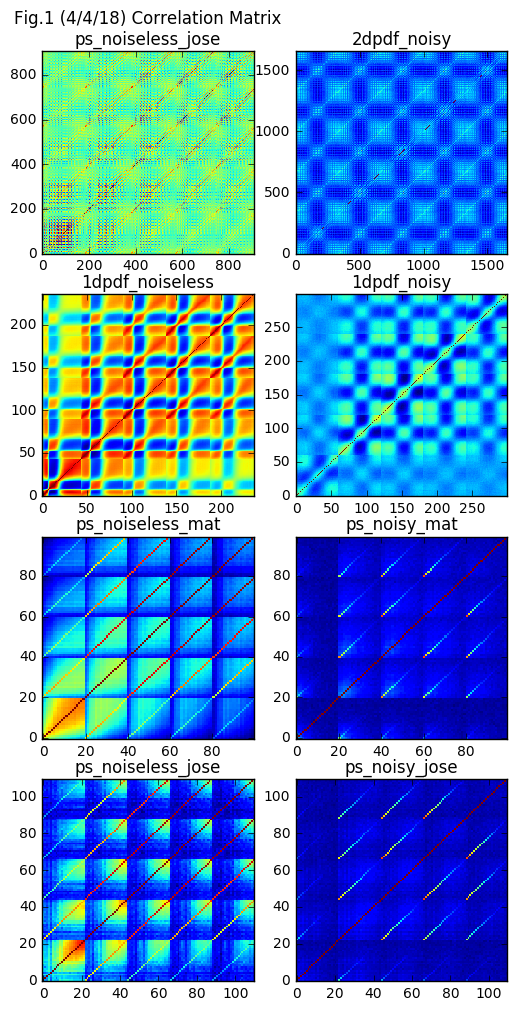

In [86]:
set_names = [['2dpdf_noiseless', '2dpdf_noisy'],
             ['1dpdf_noiseless', '1dpdf_noisy'],
             ['ps_noiseless_mat', 'ps_noisy_mat'],
             ['ps_noiseless_jose', 'ps_noisy_jose']]
cov_arr = [[cov2dI,cov2dN],
           [cov1dI,cov1dN],
           [covpsI_Mat,covpsN_Mat],
           [covpsI_Jose,covpsN_Jose]]

f, axes = subplots(4,2,figsize=(6,12))
for i in range(len(set_names)):
    axes[i][0].imshow(WLanalysis.corr_mat(cov_arr[i][0]), origin='lower',aspect='auto',interpolation='nearest')
    axes[i][1].imshow(WLanalysis.corr_mat(cov_arr[i][1]), origin='lower',aspect='auto',interpolation='nearest')
    axes[i][0].set_title(set_names[i][0])
    axes[i][1].set_title(set_names[i][1])
axes[0][0].set_title('Fig.1 (4/4/18) Correlation Matrix\n'+set_names[i][0])
show()
